<h1>CV Project: Lidar Clustering</h1>

# Description
We are given a set of Lidar and RGB images images, we are formally asked to segment the cluster of lidar.

# Import, load repo and set seeds

In [1]:
import numpy as np
import torch
import cv2
import pytorch_lightning as pl
from glob import glob
from torch import nn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from utils.dataloader.labels import Label
from easydict import EasyDict


In [2]:
# Set seeds
torch.manual_seed(420)
np.random.seed(420)

In [3]:
# Define Constants
IMG_SHAPE = (320, 1216)

# Data Visualization

In [4]:
from utils.dataloader.labels import *

In [5]:
NR_CLASSES = len(set([x.trainId for x in labels])) # default class

In [6]:
def show(data, label):
    """ Function to show"""
    data = EasyDict(data)
    left_rgb_np = data.left_rgb.numpy().transpose(1, 2, 0)
    left_sd_np = data.left_sdisp.numpy()[0]
    left_d_np = data.left_disp.numpy()[0]
    # Map Label to OneHotEncoding
    left_segm_np = RGBtoOneHot(label, {x.color:((x.trainId)) for x in labels})
    print(np.unique(left_segm_np))

    left_segm_np = RGBtoOneHot(label, {x.color:((x.trainId*30 + 20)%256) for x in labels})
    print(np.unique(left_segm_np))
    # Map label back to color
    visualize_rgb = True
    visualize_sd = True
    visualize_d = True
    visualize_segm = True

    # Visualization
    if visualize_rgb:
        _, axes = plt.subplots()
        axes.set_title('RGB (left)')
        axes.imshow(left_rgb_np)
    if visualize_sd:
        _, axes = plt.subplots()
        axes.set_title('LiDAR (left)')
        axes.imshow(left_sd_np)
    if visualize_d:
        _, axes = plt.subplots()
        axes.set_title('Depth (left)')
        # No sample on this
        axes.imshow(left_d_np)
    if visualize_segm:
        _, axes = plt.subplots()
        axes.set_title('Segmentation (left)')
        axes.imshow(left_segm_np, cmap="viridis")
    plt.show(block=False)

# Training Preparation

In [7]:
BATCH_SIZE = 2
EPOCHS = 5

In [8]:
from utils.dataloader.dataset import DatasetKITTI2015

dataset = DatasetKITTI2015(root_dir='./dataset/',
                               mode='training',
                               output_size=(352, 1224),
                               random_sampling=0.15) # Of Lidar Points


[  0.   1.   5.   6.   7.   8.   9.  12.  18. 255.]
[  4.  20.  34.  48.  50. 124. 170. 200. 230. 246.]


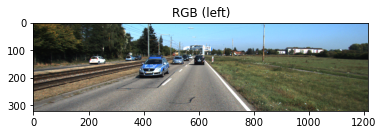

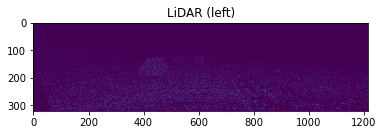

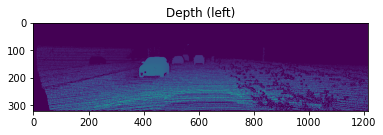

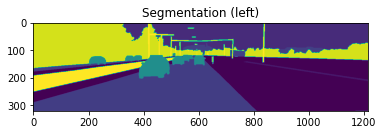

In [9]:
sample_nr = 40
show(dataset[sample_nr][0], dataset[sample_nr][1])


In [10]:
NR_SAMPLES = len(dataset)

In [11]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [13]:
from torchvision.models import efficientnet_v2_s
from sklearn.metrics import accuracy_score
from models.convnet import ConvNet
from models.unet import UNet
from torchmetrics import JaccardIndex
# Import the models and the necessary loss
metric = JaccardIndex(task="multiclass", num_classes=NR_CLASSES, ignore_index=255)
loss_fct = nn.CrossEntropyLoss(ignore_index=255)
unet = UNet(loss=loss_fct, eval_metric=metric, channels=3, f=32, output_channels=NR_CLASSES, img_shape=IMG_SHAPE, activate_clf=False)
model = unet
#model = ConvNet(unet, loss=loss_fct, eval_metric=metric, input_channels=3, output_layers=25, optimizer=torch.optim.Adam, lr=1e-4)
#model = ConvNet(unet, loss=loss_fct, eval_metric=metric, input_channels=3, output_layers=25, optimizer=torch.optim.Adam, lr=1e-4)

In [14]:
# Test model on one sample
for x, y in train_loader:
    data = x["left_rgb"]
    dict = {x.color:((x.trainId)) for x in labels}
    label = torch.tensor(list(map(lambda y: RGBtoOneHot(y, dict).astype(int), y)))
    out = model(data)
    loss = loss_fct(out, label)
    pred = torch.argmax(out, 1)
    acc = metric(pred.squeeze(), label.squeeze())
    print(loss)
    print(acc)
    break

/tmp/ipykernel_47448/2404471510.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  label = torch.tensor(list(map(lambda y: RGBtoOneHot(y, dict).astype(int), y)))


tensor(2.9766, grad_fn=<NllLoss2DBackward0>)
tensor(0.0116)


# Training Loop

In [15]:
trainer = pl.Trainer(accelerator="cpu", max_epochs=5)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ggil/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

   | Name        | Type                   | Params
--------------------------------------------------------
0  | loss        | CrossEntropyLoss       | 0     
1  | eval_metric | MulticlassJaccardIndex | 0     
2  | e1          | EncoderBlock           | 10.3 K
3  | e2          | EncoderBlock           | 55.7 K
4  | e3  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ggil/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

: 

In [ ]:
#torch.save(model.state_dict(), 'weights.pt')

In [ ]:
model.load_state_dict(torch.load("weights/unetweightsnewdata.pt"))

In [ ]:
postprocess = lbl_for_patch((16, 16), IMG_SHAPE, road_percentage=0.25)

post = transforms.Compose([
    rgb_to_gray, 
    transforms.Lambda(lambda t: cv2.resize(t, IMG_SHAPE)), 
    transform_default, 
    transforms.Lambda(lambda t: postprocess(t.squeeze()).squeeze()),
])

In [ ]:
from PIL import Image

num_imgs = 5
offset = 2 * num_imgs

fig, ax = plt.subplots(num_imgs, 5, figsize=(15, 15))

for index in range(num_imgs):

    print(data_paths_val[index][0])
    print(label_paths_val[index])

    ax[index, 0].imshow(Image.open(data_paths_val[index + offset][0]))
    ax[index, 1].imshow(Image.open(label_paths_val[index + offset]))
    ax[index, 2].imshow(post(cv2.imread(label_paths_val[index + offset])).view(25, 25).numpy())
    #ax[index, 2].imshow(label_transf1(cv2.imread(label_paths_val[index + offset])).squeeze().numpy())
    #ax[index, 2].imshow(label_transf1(cv2.imread(label_paths_val[index + offset])).view((5, 5)).squeeze().numpy())

    print(val_dataset[index][0].shape)

    model.eval()
    with torch.no_grad():    
        pred = postprocess(model(val_dataset[index + offset][0].unsqueeze(0))).view(25, 25).numpy()
        ax[index, 3].imshow(pred)    
        ax[index, 4].imshow(pred.round())        
plt.show()

In [ ]:
with open("submission.csv", 'w') as f:
        f.write('id,prediction\n')   
        for path in test_paths: 
            img_number = int(path.split('_')[1].split('.')[0])
            print(img_number)
            data = cv2.imread(path)
            data = data_transf(data)
            pred = postprocess(model(data.unsqueeze(0))).view(25, 25).numpy()
            fig, ax = plt.subplots(1, 2, figsize=(15, 15))
            ax[0].imshow(data.permute(1, 2, 0))
            ax[1].imshow(pred)
            plt.show()
            for i in range(pred.shape[0]):
                for j in range(pred.shape[1]):
                    f.write("{:03d}_{}_{},{}\n".format(img_number, i*16, j*16, int(pred[i, j])))

# Inference

model.eval()
with torch.no_grad():
    preds = torch.tensor([])
    for data, _ in tqdm(val_loader, desc="Predicting"):
        data = data.to(device)
        out = model(data)#, clf=True)
        preds = torch.cat([preds, out.cpu().detach()], dim=0)

# Postprocessing

from utils.postprocess import masks_to_labels

predictions = masks_to_labels(preds)

print(predictions[:50])